# Journey Object Engine Orchestated Jobs 

Can Journey be used to navigate a complex mission definition space?

This notebook demonstrates programmatic use of Journey's Mission Design system by way of the Journey API. This notebook does the following:
* Defines multiple PMD missions with a sweep of parameters and requests their simulation
* Builds a visualization of simulated mission data
* Selects subsystems out of PMD recommendations
* Upgrades a PMD mission to an AMD mission with parameters set to match selected subsystems and requests the its simulation
* Builds visualization of AMD simulation data

A future version might:
* Select the base PMD mission by interrogating the simulation data against meangingful criteria
* Select subsystems from recommendations against meaningful criteria

## Key Learnings
* Incompatibilities between Subsytems data and AMD requirements
    * Idle power?
    * Thruster -- prop mass
    * Battery -- maximum/recommended discharge
    * Solar Panel -- surface area & voltage
* Escaping JOEverse for simulation request & data retrieval
    * Simulations should be triggered by creating or updating a Simulation object to "STARTED" (i.e. postgrest middleware)
    * Need some sort of dataset api for simulation data files in s3 (sim data, subsystem matches, czml)
* JOE Serialization -- JOE needed to convert dict's and lists to JSON in to_json
* Too many API requests; can we support a multi-JOE-object POST and/or PATCH endpoint?

Meaningful PMD Sweeps:
* Maneuver Duration
* Maneuver Target
* Mass
* Bus Dimensions

Meaningful AMD Sweeps:
* Propulsion, Battery characteristics


# Example Mission Analysis
Goals:
    * Mission Lifetime Extension -- Maintenance for long window
    * Comparison against Chemical Propulsion (favor low burn, low thrust)
      * Maintenance for long window
    * Demo API
    * Split notebooks
       * PMD vs. AMD

Goals

In [1]:
import os
import json
import requests
from uuid import uuid4
from time import sleep
from datetime import datetime, timedelta
from io import StringIO

import matplotlib.pyplot as plt
import pandas as pd

import jwt
import joe.model as joe

## Create API Token

In [2]:
JOE_URL = "https://joe.qa.morpheus-sandbox.com"
USERNAME = ""
PASSWORD = ""

In [3]:
TOKEN = None
def refresh_token():
    global TOKEN
    TOKEN = requests.post(f"{JOE_URL}/api/auth/login/", json={"email": USERNAME, "password": PASSWORD}).json()['access']

refresh_token()

In [4]:
company_id = jwt.decode(TOKEN, options={"verify_signature": False})['company']

## Mission Sweeps

To run all of our simulations, we need to define the values that will change between each one. For this, we will be changing the satellite's bus size between all of the cubesat template sizes as well as exploring the trade-offs of 2 maneuver sets: one that first raises its semi-major axis before an inclination change and another maneuver set that reverses the order.

In [5]:
Bus_Sweep = list(joe.Bus.BUS_TEMPLATES.keys())[0]
Duration_Sweep = [15.0, 30.0, 60.0, 100.0]

deployment = joe.Orbit.ORBIT_TEMPLATES['LEO']
sma_7200 = {"semi_major_axis": 7200.0, "inclination": None, "eccentricity": None, "argument_of_perigee": None, "raan": None, "true_anomaly": None}
inclination_60 = {"semi_major_axis": None, "inclination": 60.0, "eccentricity": None, "argument_of_perigee": None, "raan": None, "true_anomaly": None}

maneuvers = [deployment, sma_7200, inclination_60]

# Define Missions by building Journey Objects

PMD Missions are defined by a collection of 5 Journey Objects: Mission, Satellite, Maneuver, Orbit, and Bus. A mission is likely to have multiple Maneuvers and Orbits, but only 1 of the other object types. In the nested loop below, we'll iterate across set of simulation targets (bus size and maneuver set) creating the Journey Objects for each simulation.

In [6]:
joes = []
by_mission = {}
by_satellite = {}
for bi, bus_size in enumerate(Bus_Sweep):
    for mi, dur in enumerate(Duration_Sweep):
        # Mission
        mission = joe.Mission(
            id=str(uuid4()),
            creation_date=datetime.utcnow().isoformat(),
            update_date=datetime.utcnow().isoformat(),
            created_by=company_id,
            name=f"JOEOJ-{bus_size:3}_D{dur}",
            launch_date=(datetime.utcnow() + timedelta(days=365)).isoformat(),
            amd_enabled=False)
        joes.append(mission)
        by_mission[mission.id] = [mission]
        # Satellite
        satellite = joe.Satellite(
            id=str(uuid4()),
            creation_date=datetime.utcnow().isoformat(),
            update_date=datetime.utcnow().isoformat(),
            name=f"JOEOJ-{bus_size:3}_MS{mi}",
            mission=mission.id)
        joes.append(satellite)
        by_mission[mission.id].append(satellite)
        # Maneuvers
        for idx, m in enumerate(maneuvers):
            maneuver_target_orbit = joe.Orbit(
                id=str(uuid4()),
                creation_date=datetime.utcnow().isoformat(),
                update_date=datetime.utcnow().isoformat(),
                **m)
            joes.append(maneuver_target_orbit)
            by_mission[mission.id].append(maneuver_target_orbit)
            mobj = joe.Maneuver(
                id=str(uuid4()),
                creation_date=datetime.utcnow().isoformat(),
                update_date=datetime.utcnow().isoformat(),
                mission=mission.id,
                name="Deployment Orbit" if idx == 0 else f"Maneuver {idx}",
                maneuver_type="analytical",
                final_orbit=maneuver_target_orbit,
                optimize=False,
                duration=dur,
                sequence_number=idx + 1)
            joes.append(mobj)
            by_mission[mission.id].append(mobj)
                
        # Bus
        bus = joe.Bus(
            id=str(uuid4()),
            creation_date=datetime.utcnow().isoformat(),
            update_date=datetime.utcnow().isoformat(),
            satellite=satellite.id,
            **joe.Bus.BUS_TEMPLATES[bus_size])
        joes.append(bus)
        by_mission[mission.id].append(bus)
        by_satellite[satellite.id] = by_mission[mission.id]

print(f"{len(by_mission)} PMD Mission Definitions:")
for mission_id, objs in by_mission.items():
    obj_types = [type(obj).__name__ for obj in objs]
    print(f"{objs[0].name} -- {obj_types}")

KeyError: '1'

# Send Mission Definitions to PMD

With our missions defined, we need to register them with PMD. To do this, we will POST each Journey Object to the Journey API.

In [ ]:
for mission_id, objs in by_mission.items():
    # Send object definitions
    for obj in objs:
        obj_type = type(obj).__name__.lower()
        raw_obj = json.loads(obj.to_json())
        raw_obj['owned_by'] = company_id
        if 'created_by' in raw_obj:
            raw_obj['created_by'] = company_id
        resp = requests.post(
            f"{JOE_URL}/{obj_type}",
            json=raw_obj,
            headers={"Authorization": f"Bearer {TOKEN}"})
        assert resp.status_code == 201, f"Failed to create {type(obj).__name__}: {resp.status_code}--{resp.text}"
    print(f"Created {objs[0].name} Definition")

# Execute Simulations

In [ ]:
for mission_id, objs in by_mission.items():
    satellite_id = objs[1].id
    resp = requests.get(
        f"{JOE_URL}/api/simulation/runsimulation/{satellite_id}",
        headers={"Authorization": f"Bearer {TOKEN}"})
    assert resp.status_code == 200, f"Failed to start Simulation {satellite_id}: {resp.status_code}--{resp.text}"
print(f"Created all Simulation Tickets")

## Poll for Sims to Complete

In [ ]:
sim_status = {mission_id: "STARTED" for mission_id in by_mission.keys()}
def num_finished():
    return sum([v in ["COMPLETED", "STOPPED"] for v in sim_status.values()])

while num_finished() != len(sim_status):
    refresh_token()
    for mission_id in by_mission.keys():
        resp = requests.get(
            f"{JOE_URL}/simulation?mission=eq.{mission_id}",
            headers={"Authorization": f"Bearer {TOKEN}"})
        assert resp.status_code == 200, f"Failed to retrieve Sim: {resp.status_code}--{resp.text}"
        sim_status[mission_id] = resp.json()[0]['status']
    print(f"{datetime.utcnow()} -- Simulations Finished: {num_finished()}/{len(by_mission)}")
    if num_finished() < len(by_mission):
        sleep(30)

## Retrieve and Visualize Sim Data

In [ ]:
refresh_token()
sids = list(by_satellite.keys())
sim_data_by_sid = {}
for sid in sids:
    sids = list(objs[1].id for objs in by_mission.values())
    resp = requests.get(
        f"{JOE_URL}/api/simulation/getsimulationdata/{sid}",
        headers={"Authorization": f"Bearer {TOKEN}"})
    sim_data_by_sid[sid] = resp.json()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
for sid, sim_data in sim_data_by_sid.items():
    # SMA
    y = [a for man in sim_data['mission']['maneuvers'] for a in man['a']]
    launch_date = datetime.fromtimestamp(sim_data['mission']['launch_date'])
    x = [launch_date + timedelta(hours=i * 2) for i in range(len(y))]
    axes[0].plot(x, y, label=by_satellite[sid][0].name)
    # Inclination
    y = [a for man in sim_data['mission']['maneuvers'] for a in man['i']]
    launch_date = datetime.fromtimestamp(sim_data['mission']['launch_date'])
    x = [launch_date + timedelta(hours=i * 2) for i in range(len(y))]
    axes[1].plot(x, y, label=by_satellite[sid][0].name)
    # Eccentricity
    y = [a for man in sim_data['mission']['maneuvers'] for a in man['e']]
    launch_date = datetime.fromtimestamp(sim_data['mission']['launch_date'])
    x = [launch_date + timedelta(hours=i * 2) for i in range(len(y))]
    axes[2].plot(x, y, label=by_satellite[sid][0].name)
axes[0].set_title("Semi-major Axis")
axes[1].set_title("Inclination")
axes[2].set_title("Eccentricity")
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.autofmt_xdate()
fig.tight_layout()

## Retrieve Subsystem Matches for each Simulation and Select Most Recommend for Each Subsystem Type

In [ ]:
subsystem_types = ['Thruster', 'ADCS', 'Battery', 'SolarPanel', 'Antenna', 'Transmitter', 'Receiver']
ss_by_sid = {}
ss_by_ss = {s: {} for s in subsystem_types}
for sid in sids:
    ss_by_sid[sid] = {}
    for ss in ['Thruster', 'ADCS', 'Battery', 'SolarPanel', 'Antenna', 'Transmitter', 'Receiver']:
        resp = requests.get(
            f"{JOE_URL}/api/subsystems/{sid}/{ss}",
            headers={"Authorization": f"Bearer {TOKEN}"})
        ss_by_sid[sid][ss] = resp.json()
        ss_by_ss[ss][sid] = ss_by_sid[sid][ss]

In [ ]:
matchCount_by_ss = {}
pid_to_payload = {}
for ss, ss_matches in ss_by_ss.items():
    matchCount_by_ss[ss] = {}
    ss_matches = list(ss_matches.values())
    all_payloads = [p for match in ss_matches for p in match['payload']]
    for payload in all_payloads:
        identifier = f"{payload['Manufacturer']}-{payload['Model']}"
        pid_to_payload[identifier] = payload
        matchCount_by_ss[ss][identifier] = 1 + matchCount_by_ss[ss].get(identifier, 0)

selected = {}
for ss, counts in matchCount_by_ss.items():
    counts = sorted(list(counts.items()), key=lambda x: x[1], reverse=True)
    selected[ss] = pid_to_payload[counts[0][0]]
{k: f"{p['Manufacturer']}-{payload['Model']}" for k, p in selected.items()}

## Build AMD Mission Definition from 3U MS0 Definition

We can upgrade a PMD mission to an AMD mission by defining additional characteristics. The next section will upgrade our existing 3U-MS0 mission for AMD using the characteristics of the selected subsystem matches from the previous section.

#### PMD -> AMD Requires:
    * Physics Definition
    * Thruster
    * Payload
    * Solar Panels
    * Battery
    * Power Budgets

In [14]:
amd_mission_id = [(mid, objs[0].name) for mid, objs in by_mission.items() if objs[0].name == "JOEOJ-3U _MS0"][0][0]
amd_mission = by_mission[amd_mission_id][0]
amd_satellite = by_mission[amd_mission_id][1]
amd_objs = []

#### Build Journey objects for chosen subsystems

In [15]:
physics = joe.Physics(
    id=str(uuid4()),
    creation_date=datetime.utcnow().isoformat(),
    update_date=datetime.utcnow().isoformat(),
    mission=amd_mission.id,
    start_time=amd_mission.launch_date,
    gravity_model="EIGEN-6S",
    atmospheric_model="NRLMSISE-00",
    third_body_model="all",
    solar_radiation_model=True,
    harmonic_degree=4,
    harmonic_order=4
)
amd_objs.append(physics)

In [16]:
payload = joe.Payload(
    id=str(uuid4()),
    creation_date=datetime.utcnow().isoformat(),
    update_date=datetime.utcnow().isoformat(),
    satellite=amd_satellite.id,
    fov_cross=40.0,
    fov_along=20.0
)
amd_objs.append(payload)

In [17]:
thruster = joe.Propulsion(
    id=str(uuid4()),
    creation_date=datetime.utcnow().isoformat(),
    update_date=datetime.utcnow().isoformat(),
    satellite=amd_satellite.id,
    type="Custom",
    prop_mass=100.0,
    isp=[float(selected['Thruster']['Attributes']['Total Impulse']['value'])],
    thrust=[float(selected['Thruster']['Attributes']['Thrust']['value'])]
)
battery = joe.Battery(
    id=str(uuid4()),
    creation_date=datetime.utcnow().isoformat(),
    update_date=datetime.utcnow().isoformat(),
    satellite=amd_satellite.id,
    voltage=float(selected['Battery']['Attributes']['Full Discharge Voltage']['value']),
    capacity=float(selected['Battery']['Attributes']['Energy Capacity']['value']),
    maximum_discharge_rate=float(selected['Battery']['Attributes']['Discharge Current Limit']['value']),
    recommended_discharge_rate=float(selected['Battery']['Attributes']['Discharge Current Limit']['value'])
)
solar_panels = [joe.SolarPanel(
    id=str(uuid4()),
    creation_date=datetime.utcnow().isoformat(),
    update_date=datetime.utcnow().isoformat(),
    satellite=amd_satellite.id,
    mount_type="Body" if selected['SolarPanel']['Attributes']['Body-Mounted or Deployable']['value'] == 'Body-Mounted' else 'Lateral',
    cell_efficiency=float(selected['SolarPanel']['Attributes']['Efficiency']['value']),
    surface_area=0.06,
    voltage=12.0,
) for i in range(3)]
amd_objs.extend([thruster, battery, *solar_panels])

#### Build Power Budget from chosen subsystems

In [18]:
power_budget = joe.PowerBudget(
    id=str(uuid4()),
    creation_date=datetime.utcnow().isoformat(),
    update_date=datetime.utcnow().isoformat(),
    satellite=amd_satellite.id,
    budget={
        "propulsion_active_power_draw": float(selected['Thruster']['Attributes']['Power']['value']),
        "adcs_active_power_draw": float(selected['ADCS']['Attributes']['Power']['value']),
        "telekom_active_power_draw": float(selected['Antenna']['Attributes']['Peak Power']['value'])
            + float(selected['Transmitter']['Attributes']['Peak Power']['value'])
            + float(selected['Receiver']['Attributes']['Peak Power']['value'])
    }
)

amd_objs.append(power_budget)

### Send AMD Objects to Journey

In [20]:
refresh_token()
for obj in amd_objs:
    obj_type = type(obj).__name__.lower()
    raw_obj = json.loads(obj.to_json())
    raw_obj['owned_by'] = company_id
    if 'created_by' in raw_obj:
        raw_obj['created_by'] = company_id
    resp = requests.post(
        f"{JOE_URL}/{obj_type}",
        json=raw_obj,
        headers={"Authorization": f"Bearer {TOKEN}"})
    assert resp.status_code == 201, f"Failed to create {type(obj).__name__}: {resp.status_code}--{resp.text}"

resp = requests.patch(
    f"{JOE_URL}/mission?id=eq.{amd_mission.id}",
    json={
        "update_date": datetime.utcnow().isoformat(),
        "amd_enabled": True
    },
    headers={"Authorization": f"Bearer {TOKEN}"})
assert resp.status_code == 204, f"Failed to update Mission: {resp.status_code}--{resp.text}"

print(f"Updated {amd_mission.name} to AMD")

Updated JOEOJ-3U _MS0 to AMD


#### Request AMD Simulation

In [21]:
refresh_token()
resp = requests.post(
    f"{JOE_URL}/api/amd/simulation/{amd_mission.id}/",
    headers={"Authorization": f"Bearer {TOKEN}"})
assert resp.status_code == 200, f"Failed to update Mission: {resp.status_code}--{resp.text}"

#### Poll for AMD Sim Result

In [22]:
finished = False
while not finished:
    refresh_token()
    resp = requests.get(
        f"{JOE_URL}/simulation?mission=eq.{amd_mission.id}",
        headers={"Authorization": f"Bearer {TOKEN}"})
    assert resp.status_code == 200, f"Failed to retrieve Sim: {resp.status_code}--{resp.text}"
    sim_status = resp.json()[0]['status']
    finished = sim_status in ['COMPLETED', 'STOPPED']
    print(f"{datetime.utcnow()} -- Completed? {finished}")
    if not finished:
        sleep(30)

2024-06-04 18:36:02.279676 -- Completed? True


#### Retrieve and Visualize AMD Sim Results

In [15]:
data = {}
refresh_token()
for data_type in ["orbital_elements", "power", "propulsion"]:
    resp = requests.get(
        f"{JOE_URL}/api/amd/simulation/3869c904-bec3-43d8-b6aa-2c6086e9823b/export/{data_type}",
        headers={"Authorization": f"Bearer {TOKEN}"})
    data[data_type] = pd.read_csv(StringIO(resp.text))

# Plot Orbital Elements

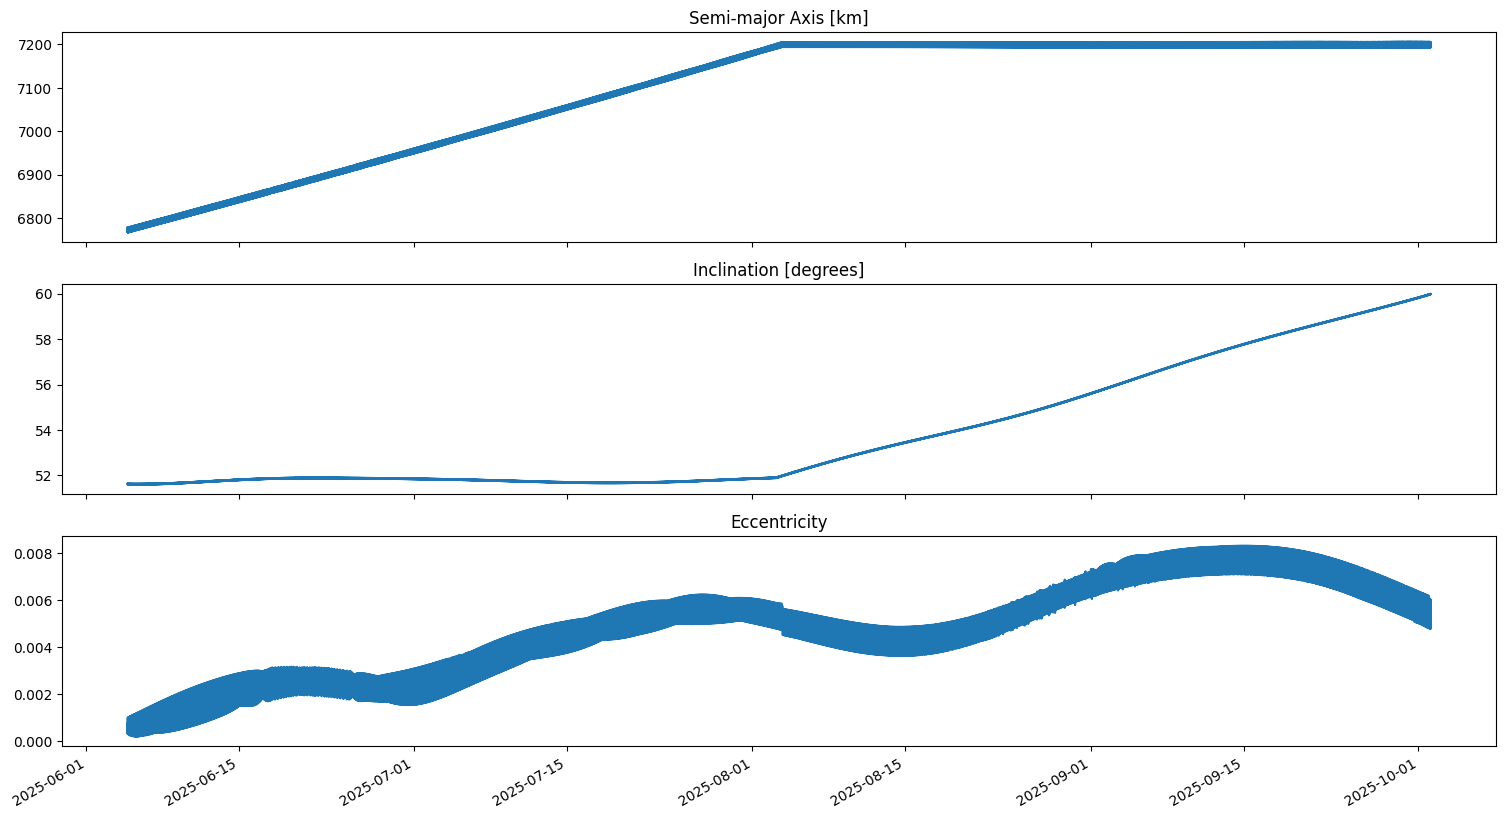

In [16]:
df = data['orbital_elements']

fig, axes = plt.subplots(nrows=3, ncols=1)
for elem, ax in zip(['Semi-major Axis [km]', 'Inclination [degrees]', 'Eccentricity'], axes):
    df['Time [UTC]'] = pd.to_datetime(data['orbital_elements']['Time [UTC]'], format='mixed')
    x = df['Time [UTC]']
    y = df[elem]
    ax.plot(x, y, label="3U-MS0")
    ax.set_title(elem)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.autofmt_xdate()

# Plot Power & Propulsion

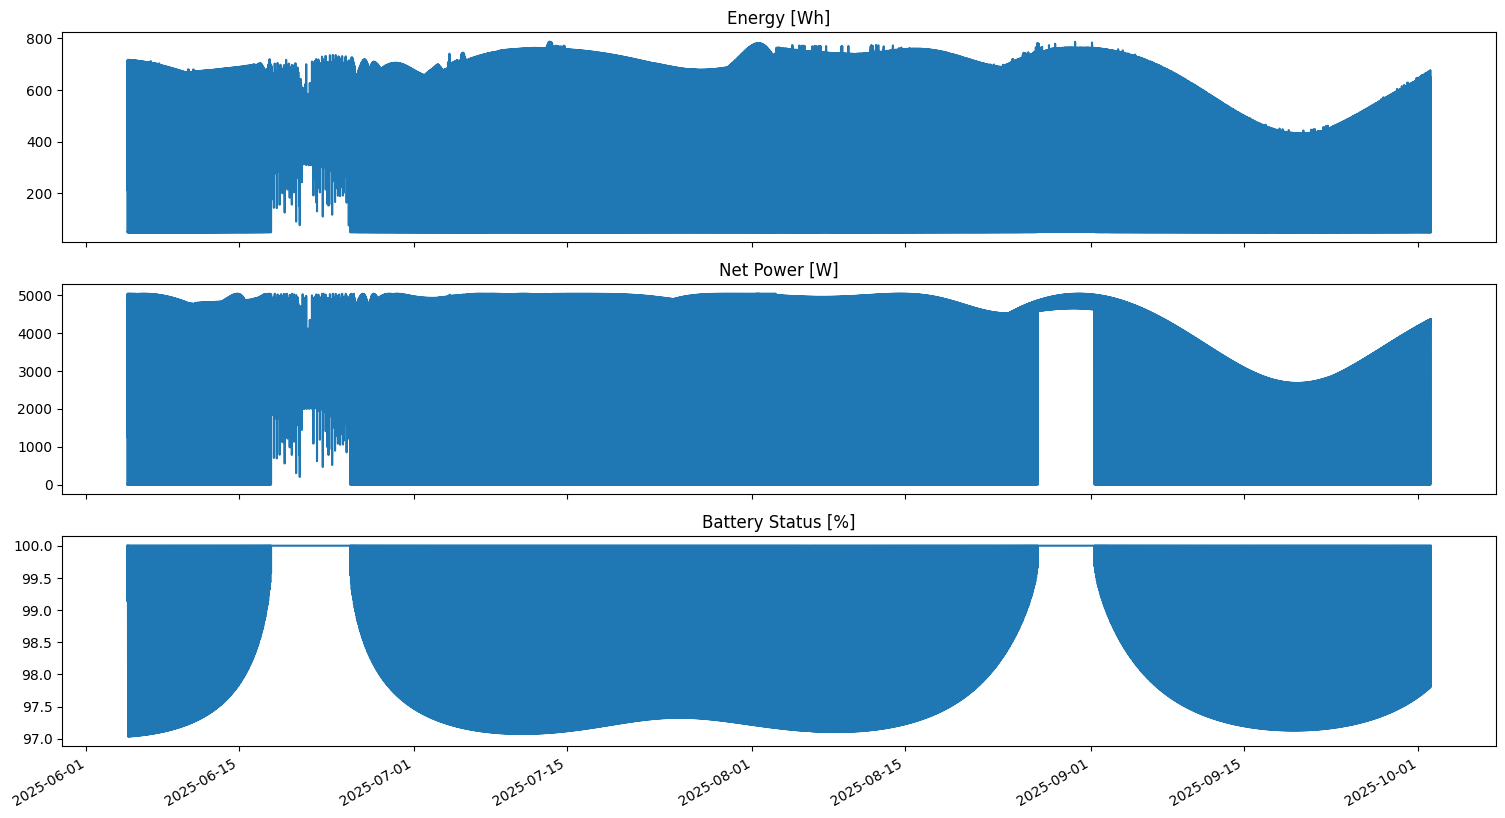

In [20]:
df = data['power']
df['Time [UTC]'] = pd.to_datetime(data['orbital_elements']['Time [UTC]'], format='mixed')

fig, axes = plt.subplots(nrows=3, ncols=1)
for elem, ax in zip(['Energy [Wh]', 'Net Power [W]', 'Battery Status [%]'], axes):
    x = df['Time [UTC]']
    y = df[elem]
    ax.plot(x, y, label="3U-MS0")
    ax.set_title(elem)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.autofmt_xdate()